In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.special import boxcox, inv_boxcox
import missingno as msno
import calendar
from sklearn.pipeline import Pipeline
from rfpimp import permutation_importances

#Regression
from sklearn.ensemble import RandomForestRegressor

#classfication
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFE

#evaluation metrics for classification
from sklearn.metrics import classification_report,f1_score,accuracy_score,r2_score 
%matplotlib inline

# Load Dataset and basic statistics visualization

In [66]:
train_df = pd.read_csv('C:\\Users\\574977\\Downloads\\PycharmProjects\\Kaggle_samya\\train.csv')
test_df = pd.read_csv('C:\\Users\\574977\\Downloads\\PycharmProjects\\Kaggle_samya\\test.csv')

In [67]:
train_df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [68]:
print(train_df.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


#variable explanation
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals

In [69]:
train_df.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

In [70]:
train_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

# Basic EDA and Preprocessing

In [71]:
#missing value check
msno.matrix(train_df)

In [72]:
# As per Chebychev's rule, 3 std. deviations account for 88.8% of data. Using this approach, we filter out the rest of the data
#chebyshev rule P(|x-mean|>=k*standard_deviation)<=1 - 1/(k^2)
sns.boxplot(train_df['count'])
plt.show()

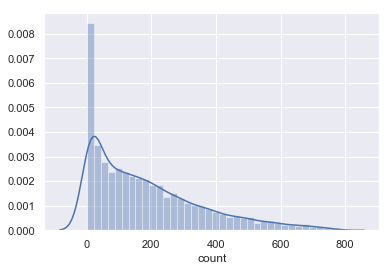

In [73]:
#density plot 'count' variable:As this is a highly skewed data, we will try to transform this data using either
#log, square-root or box-cox transformation. After trying out all three, log square gives the best result
cnt=train_df['count'].values
q99=np.percentile(cnt,[99])

train_df=train_df[train_df['count']<q99[0]]
sns.distplot(train_df['count'])
plt.show()

In [74]:
#Univariate analysis of all variables Categorical data--> Season, Holiday, WorkingDay, Weather
#holiday and working day seems coorelated
#Weather - positively skewed
#1: Clear, Few clouds, Partly cloudy, Partly cloudy - most of the data falls in this region
#4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog - very low amount of data is present in this category
cat_names=['season', 'holiday', 'workingday', 'weather']

i=0
for name in cat_names:
    i=i+1
    plt.subplot(2,2,i)
    plt.subplots_adjust(hspace = 1)
    sns.countplot(name,data=train_df) 
plt.suptitle("Categorical Analysis:Season,Holiday,Workingday,Weather", x=0.5, y=1.1, fontsize=14, fontweight="bold")  
plt.tight_layout()
plt.show()

In [75]:
#Univariate analysis for continuous data
#Temp, Atemp, humidity look normally distributed. However, windspeed has a lot of outliers -positively skewed
cont_names=['temp','atemp','humidity','windspeed']

        
#sns.boxplot(train_df['season'])   
i=0
for name in cont_names:
    i=i+1
    plt.subplot(2,2,i)
    plt.subplots_adjust(hspace = 1)
    sns.boxplot(name,data=train_df) 
plt.suptitle("Univariate Analysis:Temp,atemp,humidity,windspeed", x=0.5, y=1.1, fontsize=14, fontweight="bold")  
plt.tight_layout()
plt.show()    
plt.show()

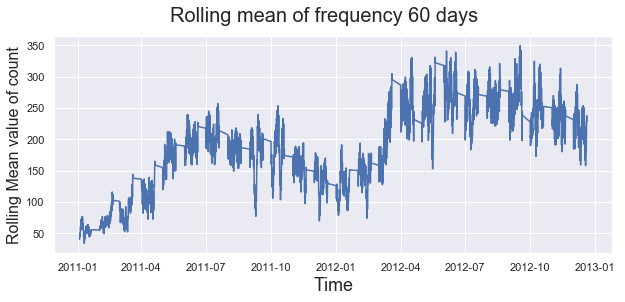

In [76]:
#Applying rolling average on a period of 60 days, as the typical weather lasts for around 3 months
#(20 days in training data of each month)
#It can be inferred that value increases with time and having a cyclic trend
train_df['datetime']=train_df['datetime'].apply(lambda x:datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'))
time_series_df=train_df
time_series_df.index=train_df['datetime']
plt.figure(figsize=(10,4))
plt.plot(time_series_df['count'].rolling(60).mean())
plt.suptitle('Rolling mean of frequency 60 days', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Rolling Mean value of count', fontsize=16)
plt.show()

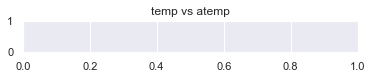

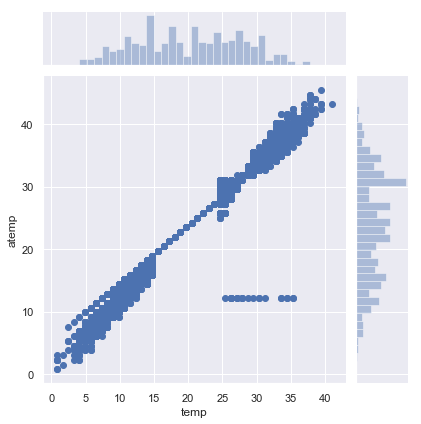

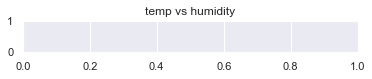

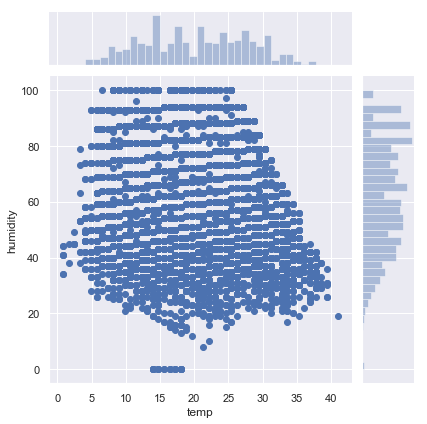

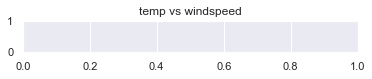

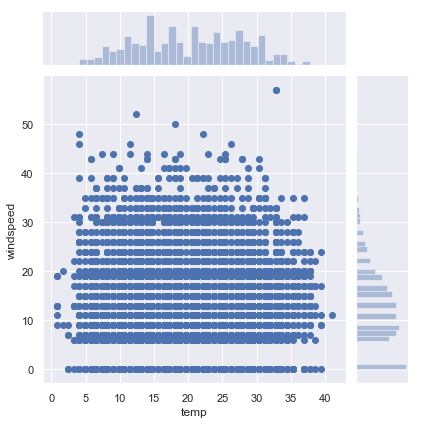

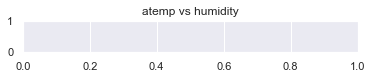

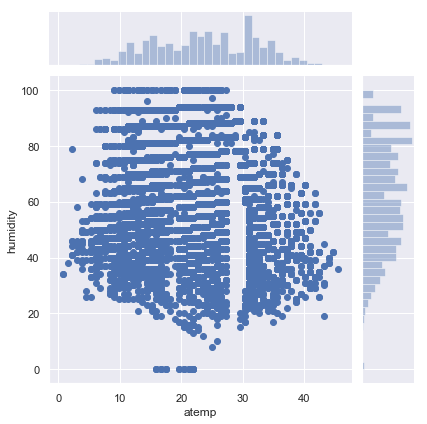

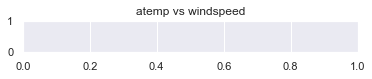

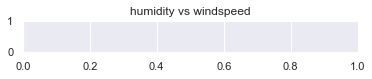

In [77]:
#Bivariate Analysis of continuous variable
#Inference :Not much can be inferred about the distribution of these variables except for variable 
#'temp' and 'atemp' that almost have similar context. 
#We would be using the 'temp' and getting rid of the 'atemp' variables for better precision value 
#and avoiding multi-collinearity.
cont_names=['temp','atemp','humidity','windspeed']
i=1
for name_1 in cont_names:
    j=cont_names.index(name_1)


    while(j<len(cont_names)-1):


        plt.subplot(6,1,i)
        plt.title(name_1+' vs '+cont_names[j+1])
        sns.jointplot(x=name_1,y=cont_names[j+1],data=train_df) 
        j=j+1
        i=i+1
        plt.show()

In [78]:
#Extracting Year,month,day,hour for feature creation
new_df=train_df
new_df["date"] = new_df.datetime.apply(lambda x : str(x).split()[0])
new_df["weekday"] = new_df.date.apply(lambda dateString : 
                                            calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
new_df['month']=new_df['datetime'].apply(lambda x:x.month)
new_df['hour']=new_df['datetime'].apply(lambda x:x.hour)
new_df['day']=new_df['datetime'].apply(lambda x:x.day)
new_df['year']=new_df['datetime'].apply(lambda x:x.year)
new_df['mnth+day']=new_df['datetime'].apply(lambda x:str(x.month)+'_'+str(x.day))

In [79]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = range(1,13)
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(new_df.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Average Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(new_df.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(new_df.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(new_df[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')
#from january to may it increases and from may to october it maintain max count then fro october to december it slowly decreases

[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across User Type'),
 None]

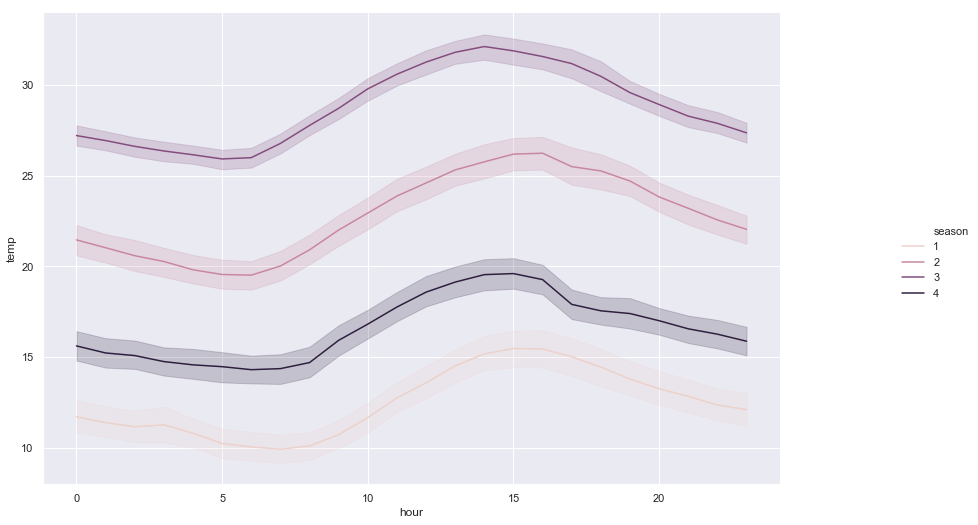

In [80]:
#Temp vs hour shows non linear relationship exist
#Binning on hourly basis can be done
sns.set(font_scale=1)
with sns.color_palette("Set1", n_colors=8, desat=.5):
    g = sns.relplot(x='hour',y='temp',data=new_df,hue='season',kind = 'line')
    g.fig.set_figwidth(15)
    g.fig.set_figheight(8)
    plt.show()

In [81]:
#corelation matrix.
cor_mat= train_df[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
#self realtion i.e. of a feature to itself is equal to 1 as expected.
#temp and atemp are highly related as expected.
#humidity is inversely related to count as expected as the weather is humid people will not like to travel on a bike.
#temp(or atemp) highly effects the count.
#weather and count are highly inversely related. This is bcoz for uour data as weather increases from (1 to 4) implies that weather is getting more worse and so lesser people will rent bikes.
#registered/casual and count are highly related which indicates that most of the bikes that are rented are registered.
#month and season are highly correlated

In [82]:
#correlation matrix
train_df.corr()

season   holiday  workingday   weather      temp     atemp  \
season      1.000000  0.030145   -0.010817  0.008974  0.258755  0.264946   
holiday     0.030145  1.000000   -0.249987 -0.007546  0.002004 -0.003614   
workingday -0.010817 -0.249987    1.000000  0.035943  0.023581  0.018510   
weather     0.008974 -0.007546    0.035943  1.000000 -0.052743 -0.053423   
temp        0.258755  0.002004    0.023581 -0.052743  1.000000  0.985282   
atemp       0.264946 -0.003614    0.018510 -0.053423  0.985282  1.000000   
humidity    0.192384  0.000788   -0.006626  0.405825 -0.058217 -0.037285   
windspeed  -0.147584  0.008659    0.012621  0.007399 -0.019430 -0.059061   
casual      0.094874  0.046419   -0.330633 -0.134227  0.461425  0.457020   
registered  0.160850 -0.015456    0.101270 -0.108182  0.307082  0.304222   
count       0.160018  0.000875   -0.013482 -0.128228  0.387515  0.383874   
month       0.971723  0.002389   -0.005883  0.012510  0.257081  0.263763   
hour       -0.008572  0.000935   -0.002239 -0.020862  0.138337  0.133509   
day         0.001907 -0.015656    0.008881 -0.006143  0.014515  0.011276   
year       -0.008825  0.013820   -0.009251 -0.010069  0.051975  0.049660   

            humidity  windspeed    casual  registered     count     month  \
season      0.192384  -0.147584  0.094874    0.160850  0.160018  0.971723   
holiday     0.000788   0.008659  0.046419   -0.015456  0.000875  0.002389   
workingday -0.006626   0.012621 -0.330633    0.101270 -0.013482 -0.005883   
weather     0.405825   0.007399 -0.134227   -0.108182 -0.128228  0.012510   
temp       -0.058217  -0.019430  0.461425    0.307082  0.387515  0.257081   
atemp      -0.037285  -0.059061  0.457020    0.304222  0.383874  0.263763   
humidity    1.000000  -0.319597 -0.342272   -0.262680 -0.316139  0.206496   
windspeed  -0.319597   1.000000  0.091620    0.094089  0.104173 -0.151158   
casual     -0.342272   0.091620  1.000000    0.495236  0.699819  0.090319   
registered -0.262680   0.094089  0.495236    1.000000  0.967147  0.167515   
count      -0.316139   0.104173  0.699819    0.967147  1.000000  0.164165   
month       0.206496  -0.151158  0.090319    0.167515  0.164165  1.000000   
hour       -0.274304   0.146080  0.295752    0.383665  0.402004 -0.008985   
day        -0.008549   0.035797  0.011213    0.013990  0.014784  0.002129   
year       -0.072691  -0.016638  0.134985    0.245989  0.241759 -0.008784   

                hour       day      year  
season     -0.008572  0.001907 -0.008825  
holiday     0.000935 -0.015656  0.013820  
workingday -0.002239  0.008881 -0.009251  
weather    -0.020862 -0.006143 -0.010069  
temp        0.138337  0.014515  0.051975  
atemp       0.133509  0.011276  0.049660  
humidity   -0.274304 -0.008549 -0.072691  
windspeed   0.146080  0.035797 -0.016638  
casual      0.295752  0.011213  0.134985  
registered  0.383665  0.013990  0.245989  
count       0.402004  0.014784  0.241759  
month      -0.008985  0.002129 -0.008784  
hour        1.000000 -0.000116 -0.011806  
day        -0.000116  1.000000  0.000065  
year       -0.011806  0.000065  1.000000

In [83]:
#With weather 1,2 and season 2,3 and working days the bicycle rental count is maximum.
#As per the analysis, we need to get rid off these variables to be inputted in our model:season. 
#Working day has better correlation with count, weather,working day, hour,year has to be label encoded
sns.set(font_scale=1)
cat_names=['season', 'holiday', 'workingday', 'weather']
i=1
for name in cat_names:
    plt.subplot(2,2,i)
    plt.subplots_adjust(hspace = 1)
    sns.barplot(x=name,y='count',data=new_df,estimator=sum)
    i=i+1
plt.tight_layout()
plt.show()

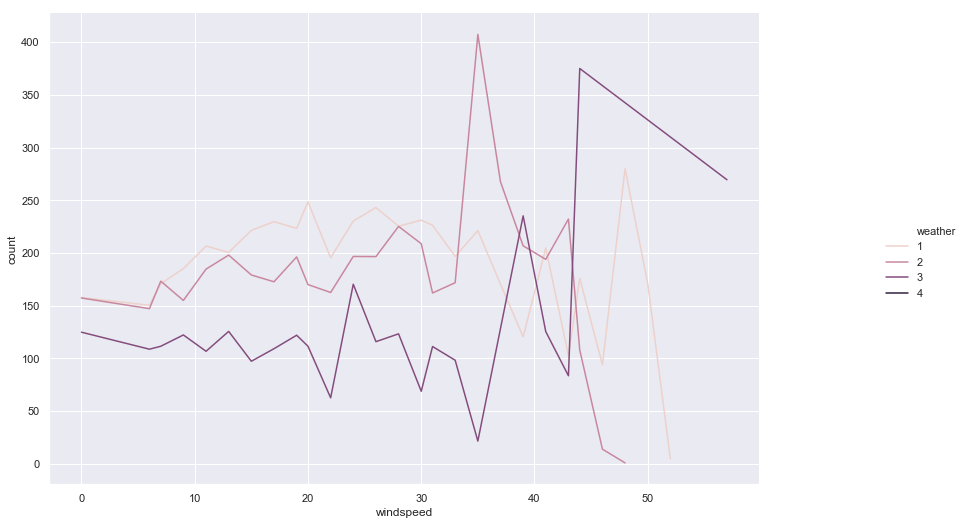

In [84]:
sns.set(font_scale=1)
with sns.color_palette("Set1", n_colors=8, desat=.5):
    g = sns.relplot(x='windspeed',y='count',data=new_df,hue='weather',kind = 'line',ci=None)
    g.fig.set_figwidth(15)
    g.fig.set_figheight(8)
    plt.show()
#higher the windspeed leads to fall in count

In [85]:
sns.set(font_scale=1)
with sns.color_palette("Set1", n_colors=8, desat=.5):
    g = sns.relplot(x='atemp',y='count',data=new_df,hue='season',kind = 'line',ci=None)
    g.fig.set_figwidth(15)
    g.fig.set_figheight(8)
    plt.show()
#count value is highest in winter   
#atemp is between  10-40 count increases rapidly
#spring is the ideal season for bicycle rental

In [86]:
final_df=new_df.drop(['datetime','temp','windspeed','casual','registered','mnth+day','day'], axis=1)
final_df.head()

season  holiday  workingday  weather   atemp  humidity  \
datetime                                                                      
2011-01-01 00:00:00       1        0           0        1  14.395        81   
2011-01-01 01:00:00       1        0           0        1  13.635        80   
2011-01-01 02:00:00       1        0           0        1  13.635        80   
2011-01-01 03:00:00       1        0           0        1  14.395        75   
2011-01-01 04:00:00       1        0           0        1  14.395        75   

                     count        date   weekday  month  hour  year  
datetime                                                             
2011-01-01 00:00:00     16  2011-01-01  Saturday      1     0  2011  
2011-01-01 01:00:00     40  2011-01-01  Saturday      1     1  2011  
2011-01-01 02:00:00     32  2011-01-01  Saturday      1     2  2011  
2011-01-01 03:00:00     13  2011-01-01  Saturday      1     3  2011  
2011-01-01 04:00:00      1  2011-01-01  Saturday      1     4  2011

In [87]:
#creating dummy variable
weather_df=pd.get_dummies(new_df['weather'],prefix='weather')
year_df=pd.get_dummies(new_df['year'],prefix='year')
month_df=pd.get_dummies(new_df['month'],prefix='month')
hour_df=pd.get_dummies(new_df['hour'],prefix='hour')
season_df=pd.get_dummies(new_df['season'],prefix='season')
                     


final_df=final_df.join(weather_df)
final_df=final_df.join(year_df)
final_df=final_df.join(month_df)                     
final_df=final_df.join(hour_df)
final_df=final_df.join(season_df)
                     
final_df.head()

season  holiday  workingday  weather   atemp  humidity  \
datetime                                                                      
2011-01-01 00:00:00       1        0           0        1  14.395        81   
2011-01-01 01:00:00       1        0           0        1  13.635        80   
2011-01-01 02:00:00       1        0           0        1  13.635        80   
2011-01-01 03:00:00       1        0           0        1  14.395        75   
2011-01-01 04:00:00       1        0           0        1  14.395        75   

                     count        date   weekday  month    ...     hour_18  \
datetime                                                   ...               
2011-01-01 00:00:00     16  2011-01-01  Saturday      1    ...           0   
2011-01-01 01:00:00     40  2011-01-01  Saturday      1    ...           0   
2011-01-01 02:00:00     32  2011-01-01  Saturday      1    ...           0   
2011-01-01 03:00:00     13  2011-01-01  Saturday      1    ...           0   
2011-01-01 04:00:00      1  2011-01-01  Saturday      1    ...           0   

                     hour_19  hour_20  hour_21  hour_22  hour_23  season_1  \
datetime                                                                     
2011-01-01 00:00:00        0        0        0        0        0         1   
2011-01-01 01:00:00        0        0        0        0        0         1   
2011-01-01 02:00:00        0        0        0        0        0         1   
2011-01-01 03:00:00        0        0        0        0        0         1   
2011-01-01 04:00:00        0        0        0        0        0         1   

                     season_2  season_3  season_4  
datetime                                           
2011-01-01 00:00:00         0         0         0  
2011-01-01 01:00:00         0         0         0  
2011-01-01 02:00:00         0         0         0  
2011-01-01 03:00:00         0         0         0  
2011-01-01 04:00:00         0         0         0  

[5 rows x 58 columns]

In [88]:
final_df = final_df.drop(['weather','year','season','month', 'hour'],axis=1)

In [89]:
print(final_df.columns)
final_df = final_df.drop(['date','weekday'],axis=1)
final_df.head(5)

Index(['holiday', 'workingday', 'atemp', 'humidity', 'count', 'date',
       'weekday', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'year_2011', 'year_2012', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'season_1', 'season_2', 'season_3', 'season_4'],
      dtype='object')


holiday  workingday   atemp  humidity  count  weather_1  \
datetime                                                                       
2011-01-01 00:00:00        0           0  14.395        81     16          1   
2011-01-01 01:00:00        0           0  13.635        80     40          1   
2011-01-01 02:00:00        0           0  13.635        80     32          1   
2011-01-01 03:00:00        0           0  14.395        75     13          1   
2011-01-01 04:00:00        0           0  14.395        75      1          1   

                     weather_2  weather_3  weather_4  year_2011    ...     \
datetime                                                           ...      
2011-01-01 00:00:00          0          0          0          1    ...      
2011-01-01 01:00:00          0          0          0          1    ...      
2011-01-01 02:00:00          0          0          0          1    ...      
2011-01-01 03:00:00          0          0          0          1    ...      
2011-01-01 04:00:00          0          0          0          1    ...      

                     hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  \
datetime                                                                    
2011-01-01 00:00:00        0        0        0        0        0        0   
2011-01-01 01:00:00        0        0        0        0        0        0   
2011-01-01 02:00:00        0        0        0        0        0        0   
2011-01-01 03:00:00        0        0        0        0        0        0   
2011-01-01 04:00:00        0        0        0        0        0        0   

                     season_1  season_2  season_3  season_4  
datetime                                                     
2011-01-01 00:00:00         1         0         0         0  
2011-01-01 01:00:00         1         0         0         0  
2011-01-01 02:00:00         1         0         0         0  
2011-01-01 03:00:00         1         0         0         0  
2011-01-01 04:00:00         1         0         0         0  

[5 rows x 51 columns]

# Considering Lag variable

In [90]:
new_df_t = pd.DataFrame()
for i in range(30,0,-1):
	new_df_t['t-'+str(i)] = train_df['count'].shift(i)
new_df_t['t'] = train_df['count'].values

In [91]:
new_df_t1 = new_df_t.dropna()
new_df_t1.head()

t-30  t-29  t-28  t-27  t-26  t-25  t-24  t-23  t-22  \
datetime                                                                    
2011-01-02 07:00:00  16.0  40.0  32.0  13.0   1.0   1.0   2.0   3.0   8.0   
2011-01-02 08:00:00  40.0  32.0  13.0   1.0   1.0   2.0   3.0   8.0  14.0   
2011-01-02 09:00:00  32.0  13.0   1.0   1.0   2.0   3.0   8.0  14.0  36.0   
2011-01-02 10:00:00  13.0   1.0   1.0   2.0   3.0   8.0  14.0  36.0  56.0   
2011-01-02 11:00:00   1.0   1.0   2.0   3.0   8.0  14.0  36.0  56.0  84.0   

                     t-21 ...   t-9   t-8   t-7   t-6   t-5  t-4  t-3   t-2  \
datetime                  ...                                                 
2011-01-02 07:00:00  14.0 ...  34.0  28.0  39.0  17.0  17.0  9.0  6.0   3.0   
2011-01-02 08:00:00  36.0 ...  28.0  39.0  17.0  17.0   9.0  6.0  3.0   2.0   
2011-01-02 09:00:00  56.0 ...  39.0  17.0  17.0   9.0   6.0  3.0  2.0   1.0   
2011-01-02 10:00:00  84.0 ...  17.0  17.0   9.0   6.0   3.0  2.0  1.0   8.0   
2011-01-02 11:00:00  94.0 ...  17.0   9.0   6.0   3.0   2.0  1.0  8.0  20.0   

                      t-1   t  
datetime                       
2011-01-02 07:00:00   2.0   1  
2011-01-02 08:00:00   1.0   8  
2011-01-02 09:00:00   8.0  20  
2011-01-02 10:00:00  20.0  53  
2011-01-02 11:00:00  53.0  70  

[5 rows x 31 columns]

In [92]:
array = new_df_t1.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = new_df_t1.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.figure(figsize=(20,10))
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names,rotation=90)
plt.show()

[0.00210212 0.00571576 0.00323933 0.0029084  0.0027478  0.0026162
 0.00421855 0.04081018 0.0152969  0.00375418 0.00743993 0.0067537
 0.00454888 0.00235406 0.00255807 0.0025963  0.00272372 0.00690815
 0.01555709 0.00458515 0.01779925 0.01893887 0.00383627 0.00385915
 0.00939353 0.00343381 0.02163104 0.03362324 0.01969273 0.72835764]


In [55]:
array = new_df_t1.values
X = array[:,0:-1]
y = array[:,-1]
# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), 1)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = new_df_t1.columns.values[0:-1]
for i in range(len(fit.support_)):
	if fit.support_[i]:
		print(names[i])
# plot feature rank
names = new_df_t1.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.figure(figsize=(20,10))
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names,rotation=90)
plt.show()

Selected Features:
t-1


In [93]:
final_df['Count_lag1'] =  new_df_t['t-1']

In [94]:
final_df = final_df.dropna()

In [95]:
final_df.head(5)

holiday  workingday   atemp  humidity  count  weather_1  \
datetime                                                                       
2011-01-01 01:00:00        0           0  13.635        80     40          1   
2011-01-01 02:00:00        0           0  13.635        80     32          1   
2011-01-01 03:00:00        0           0  14.395        75     13          1   
2011-01-01 04:00:00        0           0  14.395        75      1          1   
2011-01-01 05:00:00        0           0  12.880        75      1          0   

                     weather_2  weather_3  weather_4  year_2011     ...      \
datetime                                                            ...       
2011-01-01 01:00:00          0          0          0          1     ...       
2011-01-01 02:00:00          0          0          0          1     ...       
2011-01-01 03:00:00          0          0          0          1     ...       
2011-01-01 04:00:00          0          0          0          1     ...       
2011-01-01 05:00:00          1          0          0          1     ...       

                     hour_19  hour_20  hour_21  hour_22  hour_23  season_1  \
datetime                                                                     
2011-01-01 01:00:00        0        0        0        0        0         1   
2011-01-01 02:00:00        0        0        0        0        0         1   
2011-01-01 03:00:00        0        0        0        0        0         1   
2011-01-01 04:00:00        0        0        0        0        0         1   
2011-01-01 05:00:00        0        0        0        0        0         1   

                     season_2  season_3  season_4  Count_lag1  
datetime                                                       
2011-01-01 01:00:00         0         0         0        16.0  
2011-01-01 02:00:00         0         0         0        40.0  
2011-01-01 03:00:00         0         0         0        32.0  
2011-01-01 04:00:00         0         0         0        13.0  
2011-01-01 05:00:00         0         0         0         1.0  

[5 rows x 52 columns]

In [96]:
#Binning decision - no of bins need to be make
per =[10,15,25,30,40,50,60,70,80,90,99,100]
for i in per:
    p1 = np.percentile(final_df['count'], i)
    print(i,'th percentile: ',p1)   

10 th percentile:  9.0
15 th percentile:  16.0
25 th percentile:  41.0
30 th percentile:  60.0
40 th percentile:  99.0
50 th percentile:  142.0
60 th percentile:  189.0
70 th percentile:  244.0
80 th percentile:  319.0
90 th percentile:  436.0
99 th percentile:  686.0
100 th percentile:  774.0


In [97]:
final_df['Binned_count']  =  pd.cut(final_df['count'], bins=[0,50,100,150,250,400,800],labels=['C0_50','C50_100','C100_150',
                                                                                              'C150_250','C250_400','C400_800'])

In [61]:
#final_df = final_df.drop(['count'],axis=1)

In [42]:
#final_df = final_df.reset_index(drop=True)

# Train-Test splitting and Modelling

In [101]:
X = final_df.drop(['Binned_count'],axis=1)
y = final_df['Binned_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify =y,random_state = 42)

In [107]:
train_count = X_train['count']

In [111]:
X_train = X_train.drop(['count'],axis=1)

In [112]:
test_count = X_test['count']

In [113]:
X_test = X_test.drop(['count'],axis=1)

In [114]:
print(X_train.shape,X_test.shape)

(9698, 51) (1078, 51)


In [115]:
# calculate sparsity
sparsity = 1.0 - np.count_nonzero(X_train) / X_train.size
print(sparsity)

0.8293624317122188


In [116]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(n_estimators=200,max_depth=10,subsample=0.8,learning_rate=0.01),
    LGBMClassifier(boosting_type='rf',bagging_fraction=0.8,pos_bagging_fraction=0.8,bagging_freq=1,
                   n_estimators=200,learning_rate=0.01,num_leaves=70,subsample=0.8)
    ]
for classifier in classifiers:
    pipe = Pipeline([('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
model score: 0.727
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


C:\Users\574977\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


model score: 0.760
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
model score: 0.794
LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='rf',
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, 

# Hyperparameter tuning, cross validation and Best model final selection by scoring metrics

In [43]:
#gradientboostclassifier
clf_gbc = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

In [44]:
# specify parameters and distributions to sample from
param_dist = {
              "learning_rate":(0.001,0.1),
              "min_samples_split": (2, 10),
              "min_samples_leaf" : (1,20),
              "n_estimators":(100,500)}

In [45]:
#Randomized search
random_search_rf = RandomizedSearchCV(clf_gbc, param_distributions=param_dist,
                                   n_iter=5, cv=5, iid=False)

In [46]:
random_search_rf.fit(X_train,y_train)
test_pred_rf = random_search_rf.predict(X_test)

In [47]:
print(random_search_rf.best_score_)
print(random_search_rf.best_params_)

0.7951187818182854
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1}


In [117]:
#gradientboostclassifier
clf_gbc_rs = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

In [119]:
clf_gbc_rs.fit(X_train,y_train)
test_pred_rf = clf_gbc_rs.predict(X_test)

In [120]:
print('accuracy %s' % accuracy_score(test_pred_rf, y_test).round(2))
print('f1-score %s' % f1_score(test_pred_rf, y_test,average='weighted').round(2))
print(classification_report(y_test,test_pred_rf))

accuracy 0.81
f1-score 0.81
              precision    recall  f1-score   support

       C0_50       0.96      0.92      0.94       297
    C100_150       0.66      0.66      0.66       124
    C150_250       0.74      0.81      0.77       207
    C250_400       0.77      0.72      0.74       181
    C400_800       0.88      0.86      0.87       133
     C50_100       0.71      0.75      0.73       136

    accuracy                           0.81      1078
   macro avg       0.79      0.79      0.79      1078
weighted avg       0.81      0.81      0.81      1078



In [134]:
print(set(y_test))


{'C400_800', 'C100_150', 'C250_400', 'C50_100', 'C0_50', 'C150_250'}


In [138]:
map_test = {'C400_800':600, 'C100_150':75, 'C250_400':325, 'C50_100':75, 'C0_50':25, 'C150_250':200}

In [145]:
test_pred_rf1 = pd.DataFrame({'Predicted':test_pred_rf})
test_pred_rf1.head()

Predicted
0     C0_50
1   C50_100
2     C0_50
3  C250_400
4   C50_100

In [148]:
test_pred_rf1['count'] = test_pred_rf1.Predicted.apply(lambda x: map_test.get(x))

In [154]:
print(test_count.shape,test_pred_rf1['count'].shape)

(1078,) (1078,)


In [162]:
test_pred_rf1.index = test_count.index

In [164]:
test_df = pd.DataFrame({'True':test_count,'Predicted':test_pred_rf1['count']})

In [166]:
test_df.to_csv('test_df.csv')

Text(0,0.5,'Count')

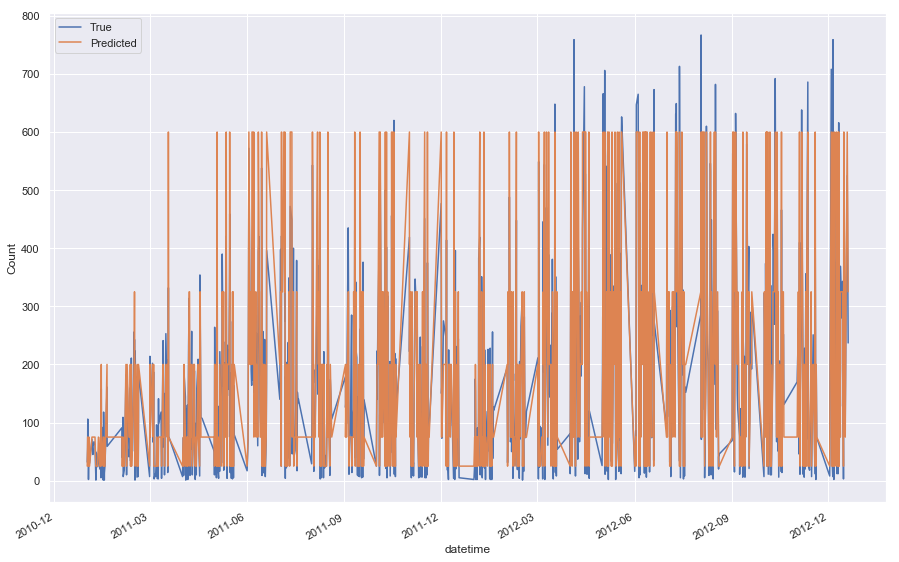

In [169]:
test_df.plot(figsize=(15,10))
plt.ylabel('Count')

In [ ]:
#grid search
"""
grid_search_rf = GridSearchCV(clf_gbc , param_grid=param_dist, cv=5, iid=False)
grid_search_rf.fit(X_train,y_train)
test_pred_grf = grid_search_rf.predict(X_test)
print(grid_search_rf.best_score_)
print(grid_search_rf.best_params_)
print('accuracy %s' % accuracy_score(test_pred_grf, y_test).round(2))
print('f1-score %s' % f1_score(test_pred_grf, y_test,average='weighted').round(2))
print(classification_report(test_pred_grf, y_pred))
"""

In [54]:
#Feature Importance
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
for name, importance in zip(X_train.columns, rf.feature_importances_):
...     print(name, "=", importance)

holiday = 0.004285886401126869
workingday = 0.036907081044280685
atemp = 0.0935061962020456
humidity = 0.08574411951645837
weather_1 = 0.012421681381281628
weather_2 = 0.011651352635721157
weather_3 = 0.008501987153406075
weather_4 = 3.239492726724906e-05
year_2011 = 0.013600565368785789
year_2012 = 0.012818604228574419
month_1 = 0.005817544404258294
month_2 = 0.0050950090192311255
month_3 = 0.005175379412886343
month_4 = 0.006612008832967063
month_5 = 0.005155252205971366
month_6 = 0.004811688174602826
month_7 = 0.004860339099484547
month_8 = 0.004659304727215486
month_9 = 0.004716627808372894
month_10 = 0.0056344809747053025
month_11 = 0.004884273257605944
month_12 = 0.005327270452220065
hour_0 = 0.01264425884752451
hour_1 = 0.012642356519580041
hour_2 = 0.012691266722681466
hour_3 = 0.016561918569346617
hour_4 = 0.014982106285848453
hour_5 = 0.01597266069617925
hour_6 = 0.010532320882576909
hour_7 = 0.01679398559873946
hour_8 = 0.020104473137691137
hour_9 = 0.014550323356481584
hour

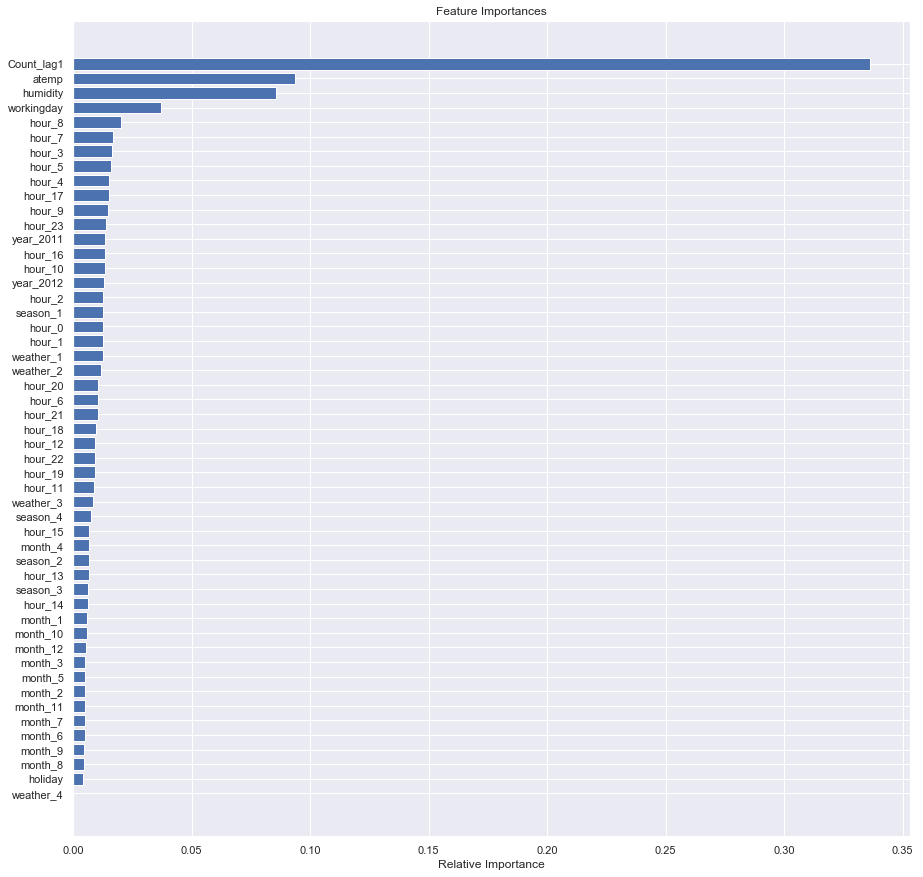

In [60]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(15,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
#From the plot important features are:Count_lag1, atemp, humidity, workingday, hour_8